In [1]:
# !pip install lifelines

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from lifelines.datasets import load_rossi

In [4]:
rossi = load_rossi()

In [5]:
rossi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   week    432 non-null    int64
 1   arrest  432 non-null    int64
 2   fin     432 non-null    int64
 3   age     432 non-null    int64
 4   race    432 non-null    int64
 5   wexp    432 non-null    int64
 6   mar     432 non-null    int64
 7   paro    432 non-null    int64
 8   prio    432 non-null    int64
dtypes: int64(9)
memory usage: 30.5 KB


In [6]:
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


| Column   | Meaning                        |
| -------- | ------------------------------ |
| `week`   | Time until arrest or censoring |
| `arrest` | 1 = re-arrested, 0 = censored  |
| `fin`    | Financial aid received         |
| `age`    | Age                            |
| `race`   | Race (binary in this dataset)  |
| `wexp`   | Work experience                |
| `mar`    | Married                        |
| `paro`   | Released on parole             |
| `prio`   | Number of prior convictions    |


In [7]:
rossi["arrest"].value_counts(normalize=True)

arrest
0    0.736111
1    0.263889
Name: proportion, dtype: float64

In [8]:
# Time-to-event distribution

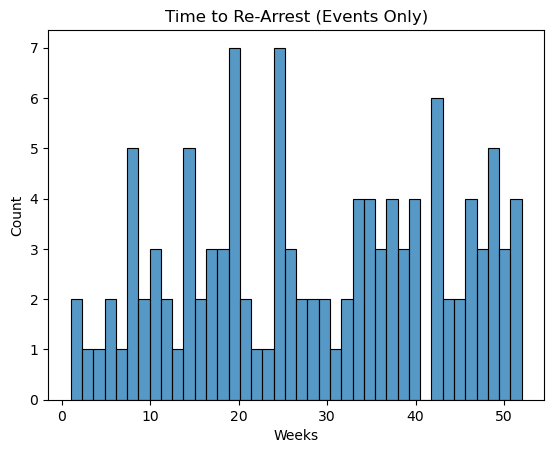

In [9]:
sns.histplot(
    rossi.loc[rossi["arrest"] == 1, "week"],
    bins=40
)
plt.title("Time to Re-Arrest (Events Only)")
plt.xlabel("Weeks")
plt.show()

In [10]:
# Survival curves

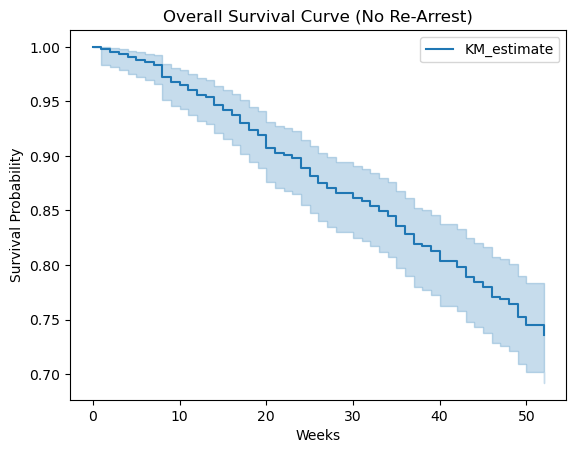

In [11]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

kmf.fit(rossi["week"], event_observed=rossi["arrest"])
kmf.plot_survival_function()
plt.title("Overall Survival Curve (No Re-Arrest)")
plt.xlabel("Weeks")
plt.ylabel("Survival Probability")
plt.show()

In [12]:
# If you make it past the early window, risk decreases

#### Kaplan–Meier survival curves represent the probability of remaining free from re-arrest over time. 

#### The downward trend reflects the accumulation of re-arrests, with steeper early declines indicating higher short-term risk. 

#### Differences between curves indicate delays or accelerations in re-arrest rather than absolute prevention.

In [13]:
# Stratified survival

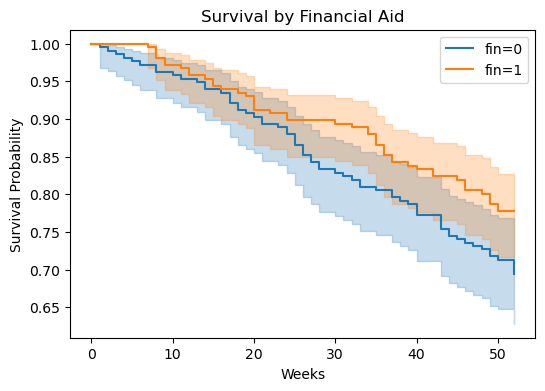

In [14]:
plt.figure(figsize=(6,4))
for label, df in rossi.groupby("fin"):
    kmf.fit(df["week"], df["arrest"], label=f"fin={label}")
    kmf.plot_survival_function()

plt.title("Survival by Financial Aid")
plt.xlabel("Weeks")
plt.ylabel("Survival Probability")
plt.show()

In [15]:
# fin = 1 curve above fin = 0 curve

In [16]:
# At any given time, a larger fraction of people with aid have not yet been re-arrested

In [17]:
# Aid buys time; it does not erase history.

In [18]:
# Work experience

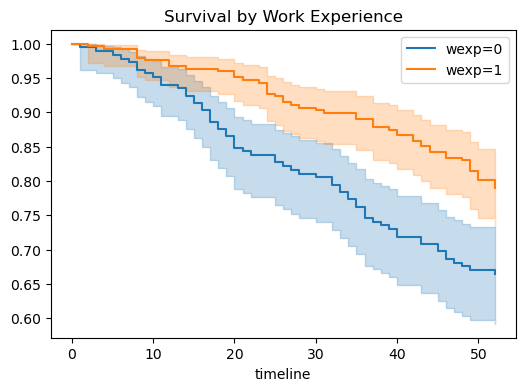

In [19]:
plt.figure(figsize=(6,4))
for label, df in rossi.groupby("wexp"):
    kmf.fit(df["week"], df["arrest"], label=f"wexp={label}")
    kmf.plot_survival_function()

plt.title("Survival by Work Experience")
plt.show()

In [20]:
# Work experience is protective

In [21]:
# Marriage

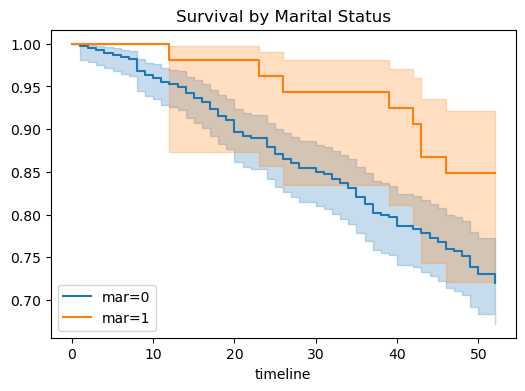

In [22]:
plt.figure(figsize=(6,4))
for label, df in rossi.groupby("mar"):
    kmf.fit(df["week"], df["arrest"], label=f"mar={label}")
    kmf.plot_survival_function()

plt.title("Survival by Marital Status")
plt.show()

In [23]:
# Prior convictions

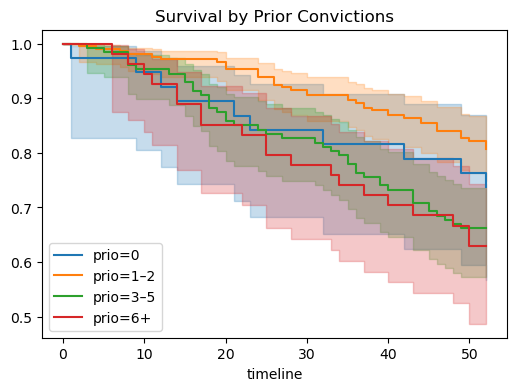

In [24]:
rossi["prio_bin"] = pd.cut(
    rossi["prio"],
    bins=[-1, 0, 2, 5, 100],
    labels=["0", "1–2", "3–5", "6+"]
)

plt.figure(figsize=(6,4))
for label, df in rossi.groupby("prio_bin", observed=True):
    kmf.fit(df["week"], df["arrest"], label=f"prio={label}")
    kmf.plot_survival_function()

plt.title("Survival by Prior Convictions")
plt.show()

#### Stratified analyses reveal that prior criminal history is the dominant structural factor shaping time to re-arrest. 

#### Individuals with higher numbers of prior convictions experience substantially faster declines in survival probability, regardless of social or policy-related supports. 

#### This suggests a strong form of path dependence, where institutional memory of past behavior outweighs short-term interventions.

In [25]:
# Past criminal history accelerates failure

In [26]:
# Age as a continuous risk modifier

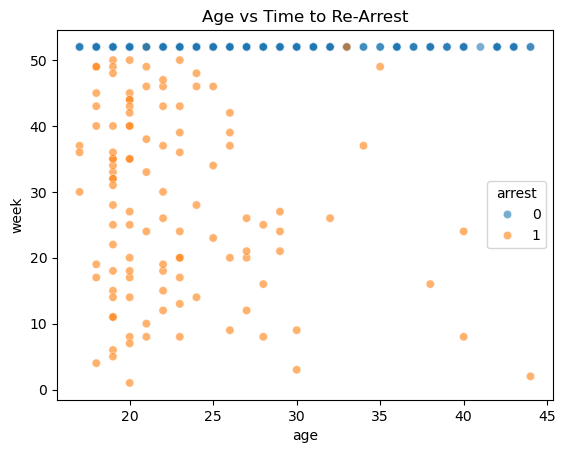

In [27]:
sns.scatterplot(
    data=rossi,
    x="age",
    y="week",
    hue="arrest",
    alpha=0.6
)
plt.title("Age vs Time to Re-Arrest")
plt.show()

In [28]:
# Younger individuals re-arrest faster, Age acts as a stabilizer

In [29]:
# Aid × priors

In [30]:
pd.crosstab(
    rossi["fin"],
    rossi["prio_bin"],
    values=rossi["arrest"],
    aggfunc="mean"
)

prio_bin,0,1–2,3–5,6+
fin,,,,
0,0.263158,0.215686,0.382353,0.481481
1,0.263158,0.171171,0.288136,0.259259


#### Recidivism risk in the Rossi dataset is heavily front-loaded, with many re-arrests occurring shortly after release. 

#### Structural history, particularly prior convictions, is the dominant predictor of time to re-arrest. 

#### Social stabilizers—such as financial aid, work experience, and marriage—delay failure but do not fully offset accumulated risk. 

#### The data suggests that institutional memory of past behavior outweighs short-term support in shaping long-term outcomes.

In [31]:
# race

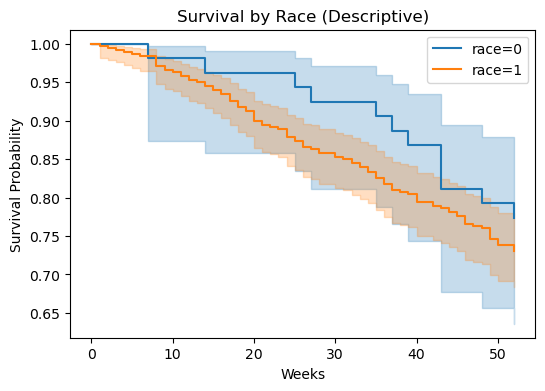

In [32]:
plt.figure(figsize=(6,4))
for label, df in rossi.groupby("race"):
    kmf.fit(df["week"], df["arrest"], label=f"race={label}")
    kmf.plot_survival_function()

plt.title("Survival by Race (Descriptive)")
plt.xlabel("Weeks")
plt.ylabel("Survival Probability")
plt.show()

#### Social stabilizers—including financial aid, work experience, and marriage—are associated with delayed re-arrest, particularly in the early post-release period. 

#### However, these factors do not eliminate recidivism risk, and their protective effects diminish among individuals with extensive prior histories. 

#### Financial aid and parole appear to buy time rather than fundamentally alter long-term trajectories.

In [33]:
# Race × prior convictions

In [34]:
pd.crosstab(
    rossi["race"],
    rossi["prio_bin"],
    values=rossi["arrest"],
    aggfunc="mean"
)

prio_bin,0,1–2,3–5,6+
race,,,,
0,NaN,0.190476,0.173913,0.444444
1,0.263158,0.192708,0.375000,0.355556


In [35]:
# parole status

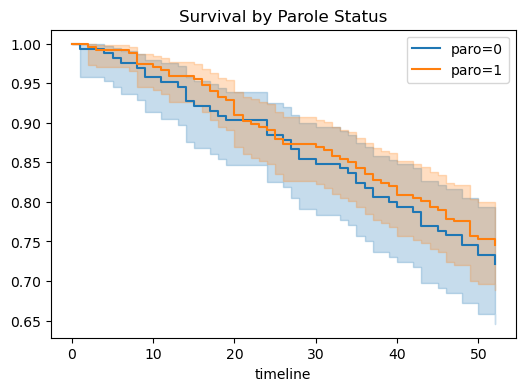

In [36]:
plt.figure(figsize=(6,4))
for label, df in rossi.groupby("paro"):
    kmf.fit(df["week"], df["arrest"], label=f"paro={label}")
    kmf.plot_survival_function()

plt.title("Survival by Parole Status")
plt.show()

In [37]:
# paro=1 curve is higher, parole delays re-arrest

In [38]:
# Parole × priors

In [39]:
pd.crosstab(
    rossi["paro"],
    rossi["prio_bin"],
    normalize="index"
)

prio_bin,0,1–2,3–5,6+
paro,,,,
0,0.109091,0.436364,0.266667,0.187879
1,0.074906,0.528090,0.310861,0.086142


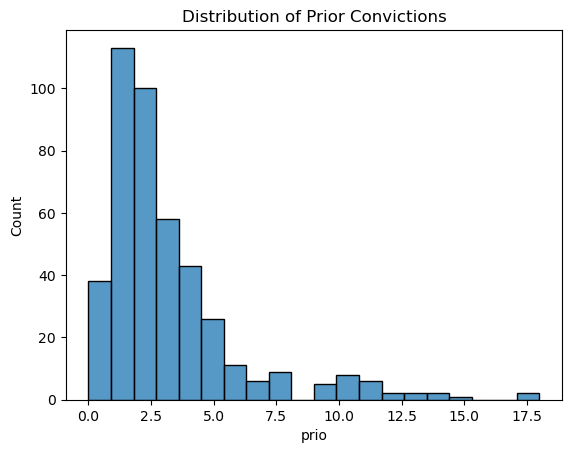

In [40]:
sns.histplot(rossi["prio"], bins=20)
plt.title("Distribution of Prior Convictions")
plt.show()

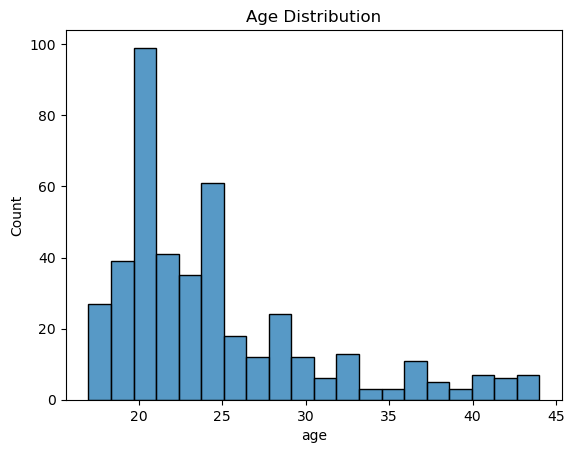

In [41]:
sns.histplot(rossi["age"], bins=20)
plt.title("Age Distribution")
plt.show()

In [42]:
# Correlation & structure

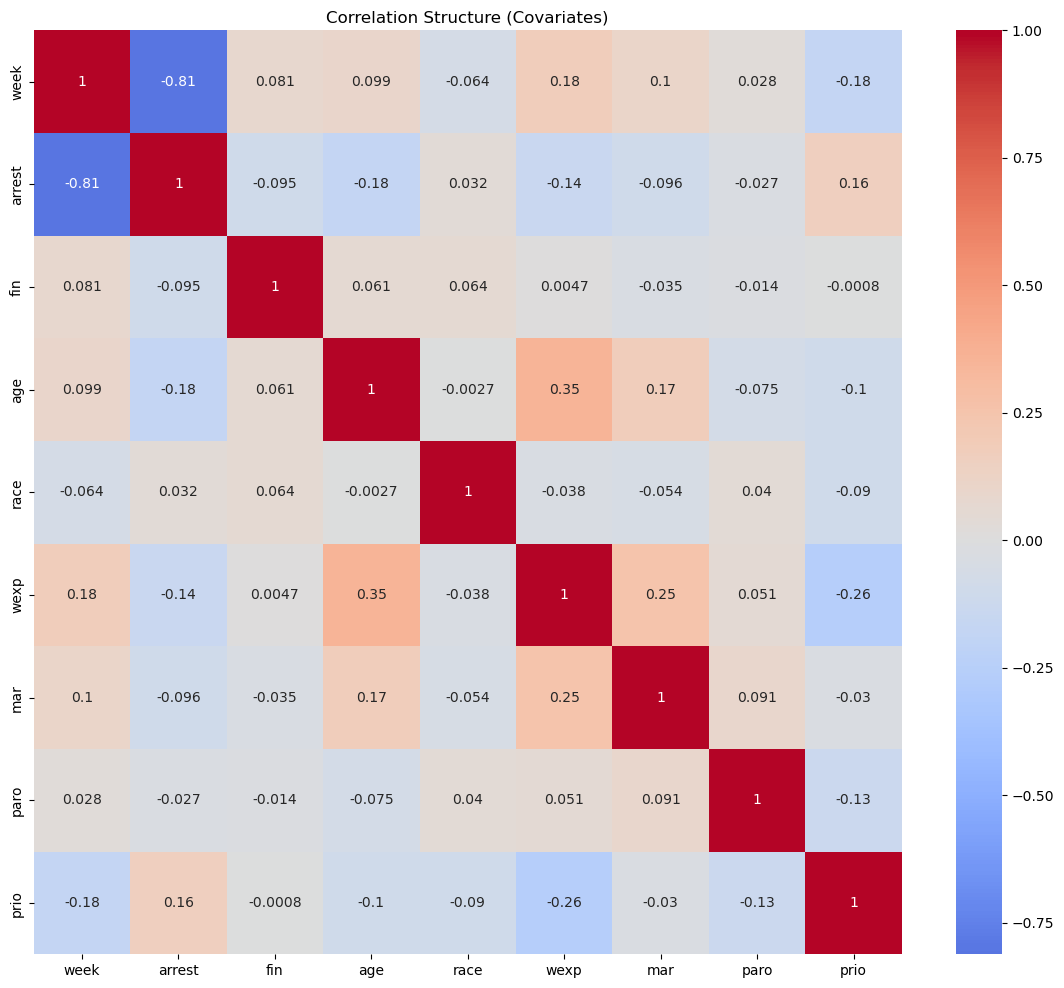

In [43]:
rossi_corr = rossi.copy()

plt.figure(figsize=(14, 12))
sns.heatmap(
    rossi_corr.drop(columns=["prio_bin"]).corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)

plt.title("Correlation Structure (Covariates)")
plt.show()

In [44]:
pd.crosstab(rossi["fin"], rossi["arrest"], normalize="index")

arrest,0,1
fin,,
0,0.694444,0.305556
1,0.777778,0.222222


In [45]:
pd.crosstab(rossi["paro"], rossi["arrest"], normalize="index")

arrest,0,1
paro,,
0,0.721212,0.278788
1,0.745318,0.254682


#### Recidivism is shaped more by structural history than by immediate support, with social interventions acting as moderators rather than reset mechanisms.